In [1]:
import pandas as pd
from pandas import Series, DataFrame
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA 
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
%matplotlib inline

data = pd.read_csv("C:/Users/SS/Desktop/2019-2nd-ml-month-with-kakr/train.csv")
test = pd.read_csv("C:/Users/SS/Desktop/2019-2nd-ml-month-with-kakr/test.csv")
sample = pd.read_csv("C:/Users/SS/Desktop/2019-2nd-ml-month-with-kakr/sample_submission.csv")

data['log_price'] = sp.log1p(data['price'])

data = data[data.sqft_living != 13540]
data= data[data.id != 2302]
data= data[data.id != 4123]
data= data[data.id != 7173]
data= data[data.id != 2775]

for i in ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement'] : 
      
        data[i] = sp.log1p(data[i])
        test[i] = sp.log1p(test[i])
        
data['date'] = data['date'].apply(lambda x : x[0:8])
test['date'] = test['date'].apply(lambda x : x[0:8])

data['yr_renovated'] = data['yr_renovated'].apply(lambda x : sp.nan if x == 0 else x )
data['yr_renovated'] = data['yr_renovated'].fillna(data['yr_built'])

test['yr_renovated'] = test['yr_renovated'].apply(lambda x : sp.nan if x == 0 else x )
test['yr_renovated'] = test['yr_renovated'].fillna(test['yr_built'])

for df in [data, test] : 
    
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')
    
data['per_price'] = data['price']/ data['sqft_total_size']
zipcode_price = data.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()

data = pd.merge(data, zipcode_price,how='left', on='zipcode')
test = pd.merge(test, zipcode_price,how='left', on='zipcode')

for df in [data, test]:
    
    df['mean'] = df['mean'] * df['sqft_total_size']
    df['var'] = df['var'] * df['sqft_total_size']
    
x_train = data.drop(['id','date','price','log_price','per_price'], axis = 1 )
y_train = data['log_price']
x_test = test.drop(['id','date'], axis = 1)

integ = pd.concat([data, test])
integ['view'] = integ['view'].astype(str)

integ = pd.get_dummies(integ)

train = integ[: 15030]
test = integ[15030 : ]

train = train.drop(['id','price','zipcode','per_price'], axis =1 )
test = test.drop(['id','zipcode','price','log_price','per_price'], axis =1)

col = [i for i in train.columns]
col.remove('log_price')

x_train = train[col]
y_train = train['log_price']

C:\Users\SS\Anaconda31\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [119]:
param_grid = {'lasso__alpha' : [0.001, 0.01,0.1,1,10,100, 1000]}
pipe = make_pipeline(MinMaxScaler(), PCA(n_components=30), Lasso()) 

grid = GridSearchCV(pipe , param_grid = param_grid , cv = 5, scoring='mean_squared_error')
grid.fit(x_train , y_train)

C:\Users\SS\Anaconda31\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\SS\Anaconda31\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\SS\Anaconda31\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\SS\Anaconda31\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\SS\Anaconda31\lib\site-packages

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='mean_squared_error', verbose=0)

In [144]:
scaler = MinMaxScaler().fit(x_train)
scaler.transform(x_train)
scaler.transform(test)

array([[0.28125, 0.3    , 0.5    , ..., 0.     , 0.     , 0.     ],
       [0.375  , 0.4    , 1.     , ..., 0.     , 0.     , 0.     ],
       [0.5625 , 0.4    , 0.5    , ..., 0.     , 0.     , 0.     ],
       ...,
       [0.3125 , 0.3    , 0.5    , ..., 0.     , 0.     , 0.     ],
       [0.09375, 0.2    , 0.5    , ..., 0.     , 0.     , 0.     ],
       [0.3125 , 0.3    , 0.5    , ..., 0.     , 0.     , 0.     ]])

In [155]:
lasso = Lasso(0.001).fit(scaler.transform(x_train), y_train).predict(scaler.transform(test))

In [157]:
lasso

array([13.29115811, 12.91016427, 14.23133786, ..., 12.97285062,
       12.57212663, 12.93371996])

In [159]:
sp.exp(lasso) - 1

array([ 591937.54927931,  404400.81953576, 1515623.09953028, ...,
        430562.72743208,  288405.61856369,  414039.8685648 ])

In [163]:
sample['price'] = sp.exp(lasso) - 1 
sample.to_csv("C:/Users/SS/Desktop/lasso.csv", index = False)

In [ ]:
scaler = MinMaxScaler().fit(x_train)
scaler.transform(x_train)
scaler.transform(test)

In [170]:
pca = PCA(n_components=28).fit(scaler.transform(x_train))
pca.transform(scaler.transform(x_train))
pca.transform(scaler.transform(test))

(6468, 28)

In [171]:
lasso = Lasso(0.001).fit(pca.transform(scaler.transform(x_train)), y_train).predict(pca.transform(scaler.transform(test)))
sp.exp(lasso) - 1 
sample['price'] = sp.exp(lasso) - 1 
sample.to_csv("C:/Users/SS/Desktop/lasso.csv", index = False)

In [173]:
from sklearn.ensemble import GradientBoostingRegressor
gra = GradientBoostingRegressor().fit(x_train.values ,y_train.values).predict(test.values)
sample['price'] = sp.exp(gra) - 1 
sample.to_csv("C:/Users/SS/Desktop/gra.csv", index = False)

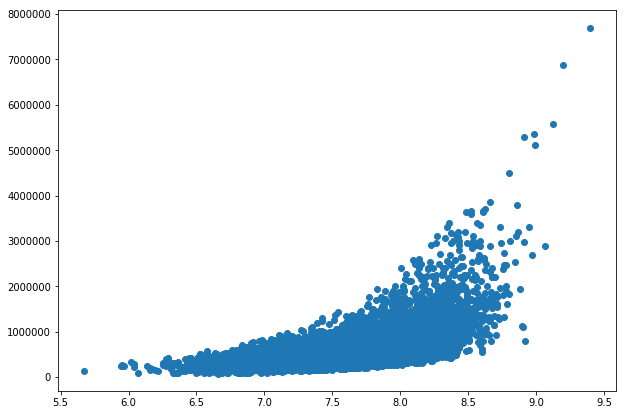

In [7]:
plt.figure(figsize = (10,7) )
plt.scatter(data.sqft_living , data.price)

In [10]:
import statsmodels.api as sm
result = sm.OLS(data.price, data.sqft_living).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                 3.754e+04
Date:                Fri, 29 Mar 2019   Prob (F-statistic):               0.00
Time:                        21:44:33   Log-Likelihood:            -2.1316e+05
No. Observations:               15030   AIC:                         4.263e+05
Df Residuals:                   15029   BIC:                         4.263e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living  7.295e+04    376.481    193.758      0.000    7.22e+04    7.37e+04
==============================================================================
Omnibus:                    14058.027   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1036610.903
Skew:                           4.323   Prob(JB):                         0.00
Kurtosis:                      42.756   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

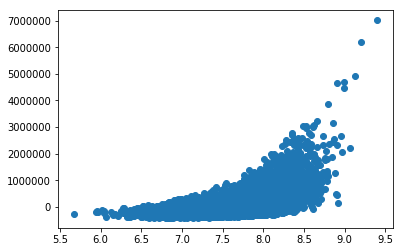

In [17]:
plt.scatter(data.sqft_living, result.resid)

In [29]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression().fit(data[['sqft_living']].values, data[['price']].values)

In [35]:
print(lin.coef_)
print(lin.intercept_)

[[528182.09576692]]
[-3448927.83050369]


In [37]:
y = -3448927.83050369 + 528182.09576692*data[['sqft_living']].values

In [39]:
y.shape

(15030, 1)

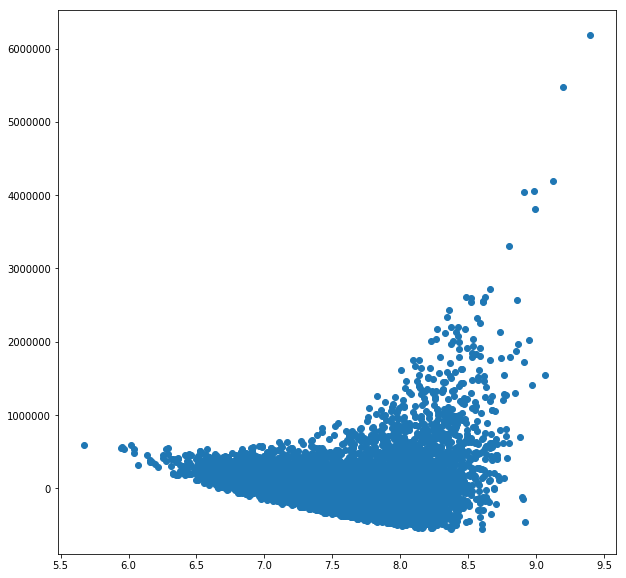

In [53]:
plt.figure(figsize = (10,10))
plt.scatter(data[['sqft_living']].values,  data[['price']].values - y ) # 등분산성, 잔차의 정규성 위배 -> 단순 선형회귀는 적절치않음.

In [49]:
data[['price']].values - y

array([[ -65594.01517544],
       [ 117737.85334962],
       [  36043.27655694],
       ...,
       [ -64588.73783118],
       [-242072.58275877],
       [ 114398.20510511]])

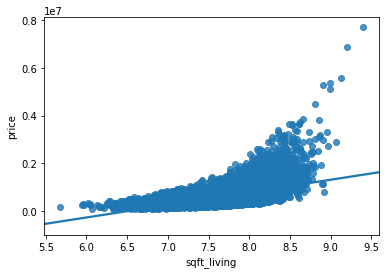

In [52]:
sns.regplot(data.sqft_living, data.price)

((array([-3.91016518, -3.69042451, -3.57002725, ...,  3.57002725,
          3.69042451,  3.91016518]),
  array([-413899.80162937, -413291.53262117, -412496.88272181, ...,
         4904212.86190488, 6213937.8797559 , 7014529.32319758])),
 (290203.15840560704, -10883.167045494427, 0.8314490188809209))

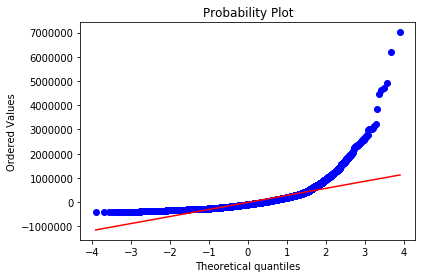

In [56]:
sp.stats.probplot(result.resid, plot =plt) # Q-Q Plot